Модель для классификации изображений из FashionMNIST датасета. Взята из ДЗ тренировок Яндекса по ML

In [2]:
import json
import os

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

In [6]:
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score

In [7]:
CUDA_DEVICE_ID = 0  # change if needed

In [8]:
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
print(device)

cpu


Text(0.5, 1.0, 'Image label: 5')

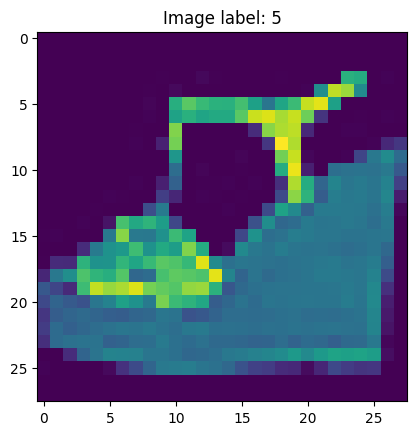

In [9]:
# Download images
train_fmnist_data = FashionMNIST(
    "../datasets", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    "../datasets", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")

In [10]:
# Creating model instance
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # (8, 20, 20)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(5, 1),
            nn.LeakyReLU()
        )
        # (16, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3),
            nn.AvgPool2d(3, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1024, 64)

        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.fc(x)
        x = F.sigmoid(x)
        # print(x.shape)
        x = self.fc2(x)
        return x

model_task_1 = CNN()

In [11]:
model_task_1.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [12]:
# your code here
def train(
    model,
    optimizer: torch.optim.Adam,
    loss_fn,
    epochs,
    device
):
    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        model.train()
        train_loss = 0.0
        # iterate over dataset
        for data in train_data_loader:
            # Write your code here
            # Move data to a device, do forward pass and loss calculation, do backward pass and run optimizer
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print("Loss/train", train_loss / 32, epoch)


train(model=model_task_1,
      optimizer=torch.optim.Adam(model_task_1.parameters(), lr=0.003, weight_decay=5e-5),
      loss_fn=nn.CrossEntropyLoss(),
      epochs=8,
      device=device)


Loss/train 27.777416117955 0
Loss/train 21.818377860588953 1
Loss/train 19.98055625637062 2
Loss/train 18.961935734492727 3
Loss/train 18.129497299785726 4
Loss/train 17.251243981649168 5
Loss/train 16.693371231434867 6
Loss/train 15.99462932208553 7


Оценим качество классификации:

In [13]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.89772


In [14]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8759


In [16]:
# Save the model
torch.save(model_task_1.state_dict(), "../../models/model.pt")

In [ ]:
# Save images for testing
unique_labels = set()
for i in range(32):
    _image, _label = random_batch[0][i], random_batch[1][i]
    if _label.item() in unique_labels: continue
    unique_labels.add(_label.item())

    plt.imsave(f'..\\..\\data\\class_{_label.item()}.png', _image.reshape(28,28), cmap='gray', format='png')

print(unique_labels)

{0, 1, 2, 4, 5, 6, 7, 8, 9}


In [41]:
model_task_1.eval()
outputs = model_task_1(random_batch[0][0].unsqueeze(0).to(device))
res = torch.argmax(outputs, dim=1).cpu()
print(outputs)
print(res.numpy()[0])


tensor([[ -2.6741,  -3.6024,   3.2878,  -4.2466,   3.8075,  -8.4456,   2.5746,
         -13.3565,  -2.6713, -11.0981]], grad_fn=<AddmmBackward0>)
4
